## GAAP vs Non GAAP: Adjusted Earnings<a name="top"></a>
Data analysis of some interesting facts to demonstrate quantitative research.<br><br>
[Introduction](#introduction)<br>
[Setup](#setup)<br>
[Read Data](#read_data)<br>
[EDA (Exploratory Data Analysis)](#explore)<br>
[Visualizing Relationships](#visual)<br>
* [Performance](#performance)<br>
* [non-GAAP Magic](#nonGAAPmagic)<br>
* [Benefit of Adjusting](#benefit)<br>
* [Usage of non-GAAP](#usage)<br>
<br>[Conclusion](#conclusion)<br>

## Introduction<a name="Introduction"></a>
The issue of GAAP vs Non-GAAP is not a new phenomenon. One of the requiremenets of companies issuing public equity or debt is the periodic filing of financial statements in accordance to generally accepted accounting principles. However, within the depths of their filings companies also report metrics that are not based on GAAP. These non-GAAP metrics, according to management, better represent the true business condition of the company and not surprisingly reflect better sales, earnings, cash flows, etc. During the internet bubble period, the use of non-GAAP metrics got to the point where mouse clicks, "eye-balls", referals, customer retention, etc. were viewed by management and by investors as more important than the notions of profitability or cash flow. Given the dearth of actual cash transactions, other quantifiable transaction became the new metric.<br><br>
What is relatively new, is their disclosure.  Following the internet bubble and the Sarbanes-Oxley Act of 2002, in 2003 FASB finalized Regulation G that required companies to provide a reconcilation of non-GAAP metrics back to their GAAP counterparts [example](#recon). In my opinion, it has been something of a double-edged sword. Better disclosure seems to have led to greater use of non-GAAP metrics as we show below and opens a new array of incomparable measures across companies and even over time within the same company. On the other hand, investors can trace back non-GAAP numbers their GAAP counterparts. This opens up the possibility for more insightful analysis.<br><br>
In this report I outline the framework of how I would perform a data driven analysis from reading the data, exploring for relationships among variables (or "features" to use data science terminology) and visualizing these relationships to tell the story. I also limit this study to non-GAAP adjusted earnings.<br>
[Top](#top)<br>

### Set-Up<a name="setup"></a>
[Top](#top)<br>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import skew
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
plt.style.use('ggplot')

### Read Data<a name="read_data"></a>
[Top](#toc)<br>

Before even trying to read data and the messy work it can often entail is the task of finding the data. There are many services that offer financial statement data and price and volume history at different price points including free. More data than ever is stored in standard formats such as JSON, csv, Excel, or in accessible databases via APIs. On the other hand, there is data that requires web scraping or worse, data entry by hand. However, in this exercise, we were able to find data from a single source.<br><br>
While formatted data is becoming easier to come by, unless one is lucky, data is seldom "good to go." Reading the data includes cleaning and validating, converting formats and data types, checking for invalid entries, handling "NAs", outliers, etc.<br><br>
I often find that recepients of data analysis are often surprised how much time and effort goes into cleaning data. Based on the "80/20 rule of thumb," data cleaning takes up the 80%.

The study covers the current S&P 500 and their histories going back 6 years for the financial statement information. Data was sourced from company filings and accessed from Bloomberg. As reported adjusted net income came from 8Ks. A sampling from the current list of stocks shows the hot links from the Bloomberg Financial Analysis (FA) function for each company linking to the appropriate 10K and 8K. The market cap is from each company's fiscal period.

As this analysis is more for illustration of data analysis than a full study, I chose only a few key variables (features):
* net income;
* adjusted net income as reported;
* market cap;
* cash flow from operations;
* total assets;
* and shares outstanding.

Below I read in data from an Excel spreadsheet. The data was brought into "Sheet1" using Bloomberg functions.

In [2]:
df = pd.read_excel('Adjusted Earnings.xlsx', sheet_name='Sheet2', skiprows=[0])

Some of the variables were calculated from the source data. The following were calculated:
* 1 year return;
* adjusted earnings yield, earnings yield and cash flow from operations yield;
* per share amounts;
* the difference between adjusted net income and net income scaled by market cap which I call \"adj_improve_gaap\"
* and a Boolean field called "neg_to_pos" which captures those company-year where GAAP EPS was negative, but non-GAAP adjusted EPS was positive.

I prefer to calculate yield since it reduces the likelihood of a zero denominator and yields are monotonic.

In [3]:
# Calculate adjusted earnings yield
df['adj_earn_yld'] = df['adj_net_inc_as_rptd'] / df['mkt_cap']
df['earn_yld'] = df['net_inc'] / df['mkt_cap']
df['cffo_yld'] = df['cffo'] / df['mkt_cap']
df['eps'] = df['net_inc'] / df['shrs_os']
df['adj_eps'] = df['adj_net_inc_as_rptd'] / df['shrs_os']
df['cfps'] = df['cffo'] / df['shrs_os']
df['adj_improve_gaap'] = (df['adj_net_inc_as_rptd'] - df['net_inc']) / df['mkt_cap']
df['neg_to_pos'] = 0
df.loc[np.logical_and(df['year'] > 0, 
                      np.logical_and(df['eps'] < 0, df['adj_eps'] >= 0)), 'neg_to_pos'] = 1
df.head()

,ticker,name,gics_ind_sect,year,adj_net_inc_as_rptd,net_inc,mkt_cap,cffo,px_last,ret,tot_ast,shrs_os,adj_earn_yld,earn_yld,cffo_yld,eps,adj_eps,cfps,adj_improve_gaap,neg_to_pos
0,MMM UN,3M CO,Capital Goods,0,NaN,4858.000,140017.9029,6240.000,235.37,0.0,37987.000,595.608,NaN,0.034696,0.044566,8.156371,NaN,10.476689,NaN,0
1,ABT UN,ABBOTT LABORATORIES,Health Care Equipment & Servic,0,4400.000,477.000,99507.3929,5570.000,57.07,0.0,76250.000,1740.601,0.044218,0.004794,0.055976,0.274043,2.527863,3.200044,0.039424,0
2,ABBV UN,ABBVIE INC,"Pharmaceuticals, Biotechnology",0,9011.000,5309.000,153974.9914,9960.000,96.71,0.0,70786.000,1596.430,0.058522,0.034480,0.064686,3.325545,5.644469,6.238921,0.024043,0
3,ABMD UW,ABIOMED INC,Health Care Equipment & Servic,0,NaN,112.170,12912.7793,192.546,290.99,0.0,786.375,44.278,NaN,0.008687,0.014911,2.533312,NaN,4.348570,NaN,0
4,ACN UN,ACCENTURE PLC-CL A,Software & Services,0,4473.092,4059.907,108159.1509,6026.691,169.07,0.0,24449.083,640.748,0.041357,0.037536,0.055721,6.336199,6.981047,9.405712,0.003820,0


I checked the first few rows of data to verify the Excel file was read correctly into the dataframe. Even in these first five rows there were several NaN ("Not a number") entries. It is often desirable to remove observations with invalid data. I do that later below.

The selection below is a sample of the 6 years of history for Xylem Inc. The number in the year column represents the number of years back from the current year which is year 0. Sector classification is based on GICS Industry Group. The return for each company is the one year forward return, so the return for all of the companies in year 0 is 0. Forward return is:

%%latex
\begin{equation}
MarketCap_{t-1} / MarketCap_t - 1
\end{equation}

In [4]:
(df[df['ticker'] == 'XYL UN'][['ticker', 'name', 'gics_ind_sect', 'year', 'adj_net_inc_as_rptd', 'net_inc', 'ret',
                               'adj_earn_yld', 'earn_yld', 'cffo_yld', 'adj_eps', 'eps', 'cfps']])

,ticker,name,gics_ind_sect,year,adj_net_inc_as_rptd,net_inc,ret,adj_earn_yld,earn_yld,cffo_yld,adj_eps,eps,cfps
501,XYL UN,XYLEM INC,Capital Goods,0,433.0,331.0,0.000000,0.035292,0.026978,0.055912,2.410913,1.842984,3.819599
1007,XYL UN,XYLEM INC,Capital Goods,1,364.0,260.0,0.377221,0.040950,0.029250,0.055913,2.029042,1.449316,2.770423
1513,XYL UN,XYLEM INC,Capital Goods,2,336.0,340.0,0.356712,0.051600,0.052215,0.071257,1.873265,1.895565,2.586889
2019,XYL UN,XYLEM INC,Capital Goods,3,362.0,337.0,-0.041240,0.052160,0.048558,0.059941,1.990378,1.852921,2.287285
2525,XYL UN,XYLEM INC,Capital Goods,4,311.0,228.0,0.100289,0.048691,0.035697,0.050727,1.685746,1.235853,1.756212
3031,XYL UN,XYLEM INC,Capital Goods,5,330.0,297.0,0.276753,0.065574,0.059017,0.078689,1.776161,1.598545,2.131393


The source data retrieved by the data provider I use can sometimes be off especially for smaller cap firms. With the S&P 500, however, this is generally not the case. The following shows that the adjusted net income does indeed come from the non-GAAP reconciliation in Xylem Inc's Form 10-K.<br>
<a name="recon"></a>
<img src="XYL_adj_net_income.jpg">

Below we count the number of observations are in the table and how many NA's we have in each column.

In [5]:
print('Number of observations in the table: {}.\n'.format(len(df)))
print('Number of NA\'s in each column:')
print(len(df) - df.count())
print('\n')
print('{} has the most NA\'s with {}.'.format((len(df) - df.count()).idxmax(), (len(df) - df.count()).max()))

Number of observations in the table: 3036.

Number of NA's in each column:
ticker                    0
name                      0
gics_ind_sect             6
year                      0
adj_net_inc_as_rptd    1128
net_inc                  32
mkt_cap                  93
cffo                     41
px_last                 120
ret                     114
tot_ast                  44
shrs_os                  61
adj_earn_yld           1152
earn_yld                 94
cffo_yld                 97
eps                      79
adj_eps                1146
cfps                     86
adj_improve_gaap       1152
neg_to_pos                0
dtype: int64


adj_earn_yld has the most NA's with 1152.


In the worst case, there are a maximum of 1151 NAs in the "adj_net_inc_as_rptd" column. This isn't surprising as in earlier years fewer companies were reporting adjusted earnings.
Below we remove the NA rows and create a new dataframe. We'll reserve the original data with the NAs to examine the extent of usage of adjusted earnings later as we mentioned above.

In [6]:
df2 = df.dropna()
print('The number of observations in the table is {}.\n'.format(len(df2)))
print('The number of NA\'s in each column is:')
len(df2) - df2.count()

The number of observations in the table is 1835.

The number of NA's in each column is:


ticker                 0
name                   0
gics_ind_sect          0
year                   0
adj_net_inc_as_rptd    0
net_inc                0
mkt_cap                0
cffo                   0
px_last                0
ret                    0
tot_ast                0
shrs_os                0
adj_earn_yld           0
earn_yld               0
cffo_yld               0
eps                    0
adj_eps                0
cfps                   0
adj_improve_gaap       0
neg_to_pos             0
dtype: int64

## Exploring the data<a name="explore"></a>
[Top](#top)

One of the things I check for is outliers. Visual inspection and stastitical descriptions of the data can help spot outliers and if necessary I winsorize the data.

<Figure size 720x360 with 0 Axes>

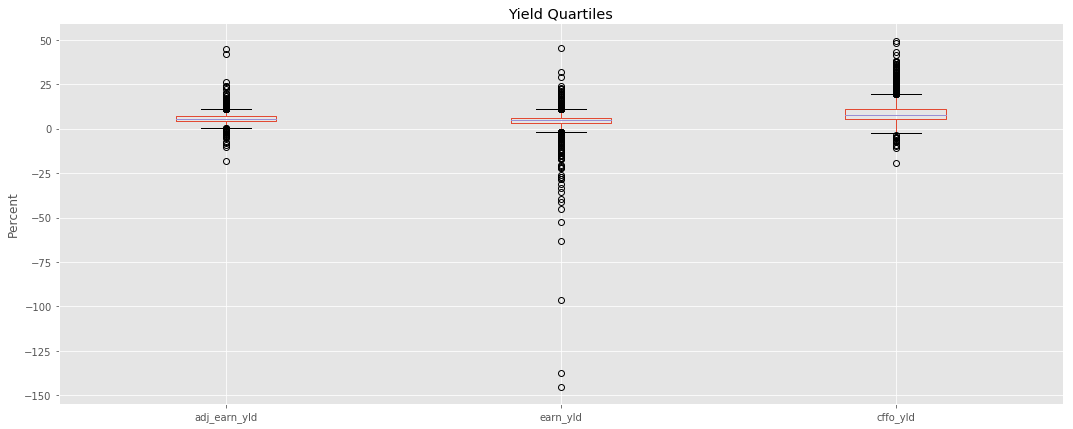

In [7]:
plt.figure(figsize=[10, 5]);
ax = ((df2[['adj_earn_yld', 'earn_yld', 'cffo_yld']] * 100)
      .plot(figsize=(18, 7), kind='box'));
plt.title('Yield Quartiles');
ax.set_ylabel('Percent');

Arguably one of the purposes of reporting adjusted earnings is to \"normalize\" earnings and remove or explain one-offs and the impact of non-operating items. The chart above does seem to show a \"normalization\" in the adjusted earnings yield plot compared to the earnings yield plot. The minimum earnings yield is -145.0% vs -18.1% for earnings yield. On the other end, the maximum earnings yield is 45.1%, whilst the highest adjusted earnigns yield is a slightly lower at 44.6%%. From the descriptive statistics calculated below, the standard deviation of the adjusted earnings yield at 3.27% is considerably narrower than the standard deviation of the earnings yield at 7.76%. Furthermore as we can see in the above, adjusted earnings yield has a positive skey and earning yield a very negative skew. This stat is calculated below confirming what we see above.<br><br>
There is an upward bias that is not readily visible in the chart (aside from the increase in the minimum mentioned above), but it is calculated in the descriptive stats below. Both the mean and median for the adjusted earnings yield are higher than for earnings yield.

In [8]:
df2[['adj_earn_yld', 'earn_yld', 'cffo_yld']].describe()

,adj_earn_yld,earn_yld,cffo_yld
count,1835.000000,1835.000000,1835.000000
mean,0.057755,0.039825,0.089674
std,0.032744,0.077610,0.061127
min,-0.181178,-1.450550,-0.195911
25%,0.042788,0.029462,0.054333
50%,0.054029,0.045882,0.074984
75%,0.069019,0.061187,0.110234
max,0.445894,0.450636,0.494608


The skewness for the different yields:

In [9]:
yld_names = ['adj_earn_yld', 'earn_yld', 'cffo_yld']
for yld in yld_names:
    print('{:15}{:.3f}'.format(yld, skew(df2[yld].values)))

adj_earn_yld   2.207
earn_yld       -9.642
cffo_yld       1.795


From the min and max there were no unreasonable outliers. The code below identifies the companies with the minimum and maximum adjusted earnings yield, earnings yield and cash flow yield values. 

In [10]:
col_list = ['adj_earn_yld', 'earn_yld', 'cffo_yld', 'ret']
for item in col_list:
    company = df2.loc[df2[[item]].idxmax()]['ticker'].item()
    year = df2.loc[df2[[item]].idxmax()]['year'].item()
    print('Company with maximum {item}:'.format(item=item))
    print(df2.loc[np.logical_and(df2['ticker'] == company, df2['year'] == year)]
          [['name', 'adj_earn_yld', 'earn_yld', 'cffo_yld', 'ret']])
    print('\n')
    company = df2.loc[df2[[item]].idxmin()]['ticker'].item()
    year = df2.loc[df2[[item]].idxmin()]['year'].item()
    print('Company with minimum {item}:'.format(item=item))
    print(df2.loc[np.logical_and(df2['ticker'] == company, df2['year'] == year)]
          [['name', 'adj_earn_yld', 'earn_yld', 'cffo_yld', 'ret']])
    print('\n\n')

Company with maximum adj_earn_yld:
                         name  adj_earn_yld  earn_yld  cffo_yld       ret
1572  ARTHUR J GALLAGHER & CO      0.445894  0.039152   0.05634 -0.130416


Company with minimum adj_earn_yld:
                        name  adj_earn_yld  earn_yld  cffo_yld       ret
1020  ADVANCED MICRO DEVICES     -0.181178 -0.285388 -0.097724  2.883562



Company with maximum earn_yld:
                     name  adj_earn_yld  earn_yld  cffo_yld       ret
2166  DELTA AIR LINES INC      0.115438  0.450636  0.192568  0.790681


Company with minimum earn_yld:
                      name  adj_earn_yld  earn_yld  cffo_yld       ret
1219  FREEPORT-MCMORAN INC     -0.011025  -1.45055  0.381724  0.948301



Company with maximum cffo_yld:
            name  adj_earn_yld  earn_yld  cffo_yld       ret
1005  XEROX CORP      0.418723 -0.212749  0.494608  0.267391


Company with minimum cffo_yld:
               name  adj_earn_yld  earn_yld  cffo_yld       ret
2686  DR HORTON INC      0.23272

It is interesting that adjusted earnings yield doesn't always result in an upward move on earnings yield. Delta Air Lines had the highest earnings yield, at 45%, yet it's adjusted earnings yield was lower at 11.5%. On the other hand the other companies display what we expect. The company with the highest adjusted earnings yield in the sample, Arthur J Gallagher & Co at 44.6%% had an earnings yield of 3.9%. AMD adjustments were a little more modest with non-GAAP earnings improving on GAAP earnings, but they were both still negative.<br><br>
Below is the snippet of Delta's earnings release for the 2013 fourth quarter showing a part of the GAAP/non-GAAP reconciliation. The biggest source of its GAAP earnings, which wasn't tied to its core operations, was the \"release of tax valuation allowance.\"

<img src="Delta Air Lines 2013Q4.png">
<br>

Below I do the same analysis, but for the per share data.

<Figure size 720x360 with 0 Axes>

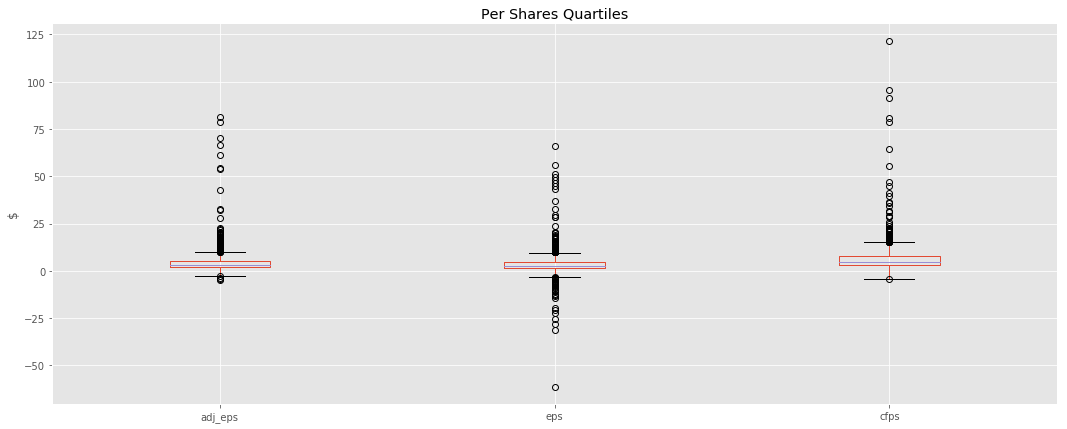

In [11]:
plt.figure(figsize=[10, 5])
ax = df2[['adj_eps', 'eps', 'cfps']].plot(figsize=(18, 7), kind='box')
plt.title('Per Shares Quartiles')
ax.set_ylabel('$');

Like the yield measures there is an upward bias. Both the mean and the median of the adjusted EPS are greater than those of EPS. But interstingly the standard deviation isn't much narrower.
Unlike the yield measures, with the per share amounts the adjusted EPS is similar to EPS, but with an upward bias.

In [12]:
df2[['adj_eps', 'eps', 'cfps']].describe()

,adj_eps,eps,cfps
count,1835.000000,1835.000000,1835.000000
mean,4.339745,3.360202,6.302879
std,5.161704,5.304470,6.903028
min,-4.702783,-61.159111,-4.496573
25%,2.070519,1.475860,2.911030
50%,3.364660,2.758717,4.808310
75%,5.283430,4.761722,7.804171
max,81.161956,65.784719,121.707471


In [13]:
per_share_names = ['adj_eps', 'eps', 'cfps']
for ps in per_share_names:
    print('{:9}{:.3f}'.format(ps, skew(df2[ps].values)))

adj_eps  8.038
eps      2.341
cfps     7.352


In [14]:
col_list = ['adj_eps', 'eps', 'cfps', 'ret']
for item in col_list:
    company = df2.loc[df2[[item]].idxmax()]['ticker'].item()
    year = df2.loc[df2[[item]].idxmax()]['year'].item()
    print('Company with maximum {item}:'.format(item=item))
    print(df2.loc[np.logical_and(df2['ticker'] == company, df2['year'] == year)]
          [['name', 'adj_eps', 'eps', 'cfps', 'ret']])
    print('\n')
    company = df2.loc[df2[[item]].idxmin()]['ticker'].item()
    year = df2.loc[df2[[item]].idxmin()]['year'].item()
    print('Company with minimum {item}:'.format(item=item))
    print(df2.loc[np.logical_and(df2['ticker'] == company, df2['year'] == year)]
          [['name', 'adj_eps', 'eps', 'cfps', 'ret']])
    print('\n\n')

Company with maximum adj_eps:
                  name    adj_eps        eps        cfps       ret
531  ALPHABET INC-CL A  81.161956  65.784719  121.707471  0.329295


Company with minimum adj_eps:
          name   adj_eps        eps      cfps       ret
738  HESS CORP -4.702783 -19.367003  2.510888 -0.237919



Company with maximum eps:
                  name    adj_eps        eps        cfps       ret
531  ALPHABET INC-CL A  81.161956  65.784719  121.707471  0.329295


Company with minimum eps:
             name   adj_eps        eps      cfps       ret
1058  APACHE CORP -0.343903 -61.159111  7.893888  0.427254



Company with maximum cfps:
                  name    adj_eps        eps        cfps       ret
531  ALPHABET INC-CL A  81.161956  65.784719  121.707471  0.329295


Company with minimum cfps:
                   name   adj_eps       eps      cfps       ret
2449  STATE STREET CORP  4.703862  4.865593 -4.496573  0.069628



Company with maximum ret:
                        name   ad

### Visualizing Relationships<a name='visual'></a>
[Top](#top)

I wrote a simple function, **makePlot**, to help us see relationships between two variables.

In [15]:
def makePlot(xVals, yVals, title, xlabel, ylabel, style, xyline=True):
    fig, ax = plt.subplots(figsize=[7, 7])
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.axhline(y=0, color='black')
    plt.axvline(x=0, color='black')
    plt.plot(xVals, yVals, style)
    if xyline is True:
        x = np.linspace(*ax.get_xlim())
        ax.plot(x, x);

Based on the box plots above, let's examine the relationship between earnings yield and adjusted earnings yield.

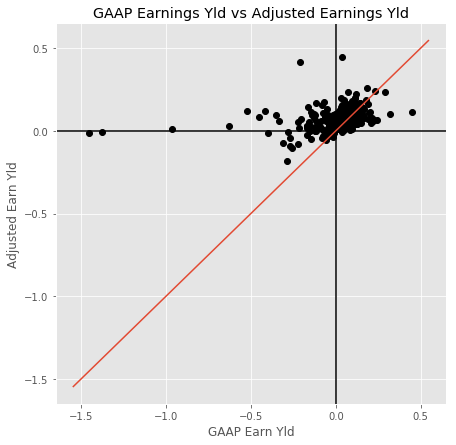

In [16]:
makePlot(df2['earn_yld'], df2['adj_earn_yld'], 'GAAP Earnings Yld vs Adjusted Earnings Yld',
         'GAAP Earn Yld', 'Adjusted Earn Yld', 'ko')

The forty-five degree line shows us the one-to-one relationship between the x and y axis. We can see that when earnings yield is below zero, adjusted earnings yield is mostly flat. When earnings yield is positive, adjusted earnigns yield is almost always positive.

As we would expect there is a positive relationship between net income and adjusted net income.

How does this compare to GAAP EPS and Adjusted EPS? Below we plot both EPS measures.

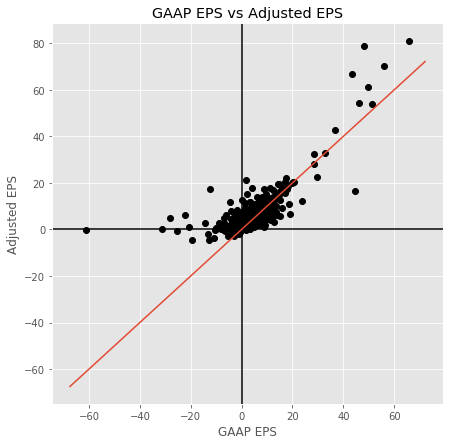

In [17]:
makePlot(df2['eps'], df2['adj_eps'], 'GAAP EPS vs Adjusted EPS',
         'GAAP EPS', 'Adjusted EPS', 'ko')

When GAAP EPS is positive there is a positive relationship between GAAP EPS and adjusted EPS around the 45 degree line. It is of course generally above the 45 degree line, but still close to it as we would expect. However, when GAAP EPS is negative, Adjusted EPS is **way above** the 45 degree line. Indeed it is almost flat! Below we run a couple of linear regressions: One when GAAP EPS is negative, another when GAAP EPS is positive.

In [18]:
below_0_eps = df2[df2['eps'] < 0]['eps'].values.reshape(-1, 1)
below_0_adj_eps = df2[df2['eps'] < 0]['adj_eps'].values
regr0 = linear_model.LinearRegression().fit(below_0_eps, below_0_adj_eps)
below_0_adj_eps_predict = regr0.predict(below_0_eps)
print('For negative eps: coef: {}, mse: {:.4f}, variance score: {:.4f}'
      .format(regr0.coef_,
              mean_squared_error(below_0_adj_eps, below_0_adj_eps_predict),
              r2_score(below_0_adj_eps, below_0_adj_eps_predict)))

For negative eps: coef: [0.01921132], mse: 8.0697, variance score: 0.0023


In [19]:
above_0_eps = df2[df2['eps'] >= 0]['eps'].values.reshape(-1, 1)
above_0_adj_eps = df2[df2['eps'] >= 0]['adj_eps'].values
regr1 = linear_model.LinearRegression().fit(above_0_eps, above_0_adj_eps)
above_0_adj_eps_predict = regr1.predict(above_0_eps)
print('For positive eps: coef: {}, mse: {:.4f}, variance score: {:.4f}'
      .format(regr1.coef_,
              mean_squared_error(above_0_adj_eps, above_0_adj_eps_predict),
              r2_score(above_0_adj_eps, above_0_adj_eps_predict)))

For positive eps: coef: [1.03806461], mse: 4.9007, variance score: 0.8225


After determining the relationships, we plot the resulting best fit lines and we can compare it to the 45 degree line.

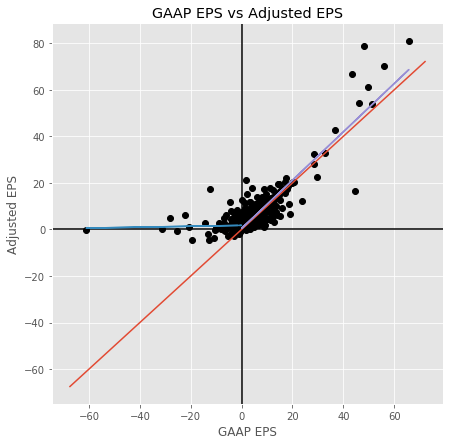

In [20]:
makePlot(df2['eps'], df2['adj_eps'], 'GAAP EPS vs Adjusted EPS',
         'GAAP EPS', 'Adjusted EPS', 'ko')
plt.plot(below_0_eps, below_0_adj_eps_predict);
plt.plot(above_0_eps, above_0_adj_eps_predict);

When GAAP EPS is positive, there will be some positive adjustments that generally resulted in a slight improvement to GAAP EPS. On average the improvement was 3.8%.

However, when GAAP EPS was negative, companies adjusted EPS was as close to 0 or even positive if possible. Statistically, there is no relationship between negative GAAP EPS and adjusted EPS! Of course, we can see how companies arrive at their adjusted EPS numbers from their non GAAP reconciliation as required by Reg G.

In [21]:
len(df2[df2['eps'] < 0]['adj_eps'])

152

The relationship between Adjusted EPS and GAAP EPS is complex as we can see above.<br><br>
It appears that for GAAP EPS less than 0, Adjusted EPS tends to be positive. For GAAP EPS at 0 and above, the Adjusted EPS grows at an increasing rate.

## Relationship with 1 Year Forward Returns<a name='performance'></a>
[Top](#top)

Below we derive a dataset with only the adjusted earnings **and** leave out year 0 data. We do this because we're only interested in periods where we have the contemporaneous future return. We want to explore the relationship between this year's adjustments and it's impact on the year.

In [22]:
df2_fwd = df2[df2['year'] > 0]

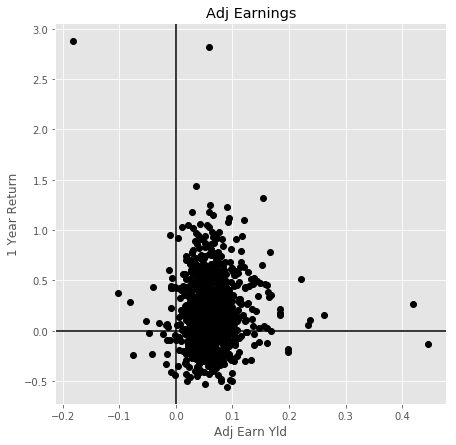

In [23]:
makePlot(df2_fwd['adj_earn_yld'], df2_fwd['ret'], 'Adj Earnings',
         'Adj Earn Yld', '1 Year Return', 'ko', xyline=False)

There doesn't appear to be a discernible pattern. It appears that the highest return happens with the lowest adjusted earnings yield and the lowest return occurs for a company with a positive adjusted earnings yield.

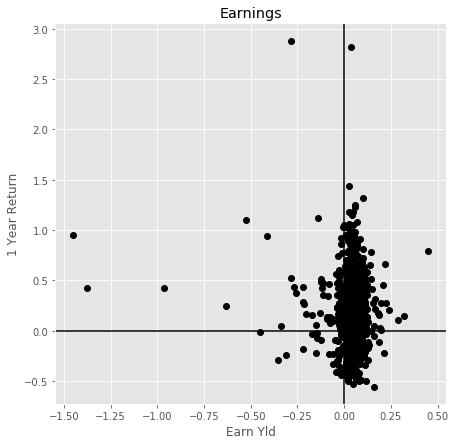

In [24]:
makePlot(df2_fwd['earn_yld'], df2_fwd['ret'], 'Earnings',
         'Earn Yld', '1 Year Return', 'ko', xyline=False)

Unlike the adjusted earnings yield chart above, the GAAP earnings yield shows a weak negative pattern! This is likely not going to be significant, but it is interesting nonetheless. 

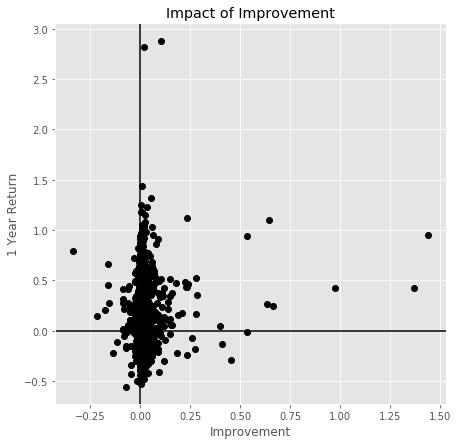

In [25]:
makePlot(df2_fwd['adj_improve_gaap'], df2_fwd['ret'], 'Impact of Improvement',
         'Improvement', '1 Year Return', 'ko', xyline=False)

However, comparing return to the degree of improvment is suggestive of a relationship.

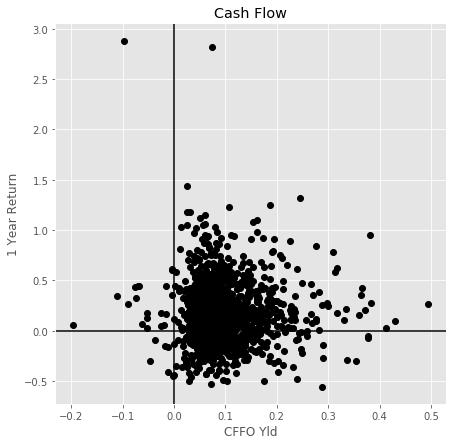

In [26]:
makePlot(df2_fwd['cffo_yld'], df2_fwd['ret'], 'Cash Flow',
         'CFFO Yld', '1 Year Return', 'ko', xyline=False)

The cash flow from operations yield shows a weak positive relationship with 1 Year Return...except for the highest return belonging to a company with negative cffo yield.

In [27]:
col_list=['adj_earn_yld', 'earn_yld', 'cffo_yld', 'adj_improve_gaap']
print('The correlation between return and:')
for item in col_list:
    print('{item:18}{corr:.4f}'
          .format(item=item, corr=np.corrcoef(df2_fwd[item], df2_fwd['ret'])[0][1]))

The correlation between return and:
adj_earn_yld      0.0100
earn_yld          -0.0842
cffo_yld          0.0068
adj_improve_gaap  0.0930


The highest correlation was between return and the amount of improvement from reporting adjusted earnings versus earnings at 10.7%. Earnings yield had a negative correlation with return. In any case, it is hard to make a concrete statement from the data, although it may somewhat support the intution that reporting adjusted earnings can help the share price.

## Negative GAAP to Positive non-GAAP<a name="nonGAAPmagic"></a>
[Top](#top)

Earlier we created a column called 'neg_to_pos' to capture those companies where non-GAAP earnings were positive when GAAP earnings were negative. Not suprisingly the average 1 year return for those companies exceeded those of companies where that wasn't the case.

In [28]:
print('\t\tAvg 1 Yr Ret\n Neg to Pos\t{:.4f}\n All Others\t{:.4f}'
      .format(df2[df2['neg_to_pos'] == 1]['ret'].mean(), df2[df2['neg_to_pos'] == 0]['ret'].mean()))

		Avg 1 Yr Ret
 Neg to Pos	0.2263
 All Others	0.1349


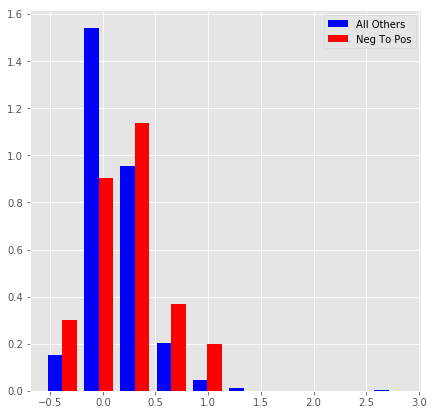

In [29]:
plt.figure(figsize=[7, 7])
plt.hist(np.array([df2[df2['neg_to_pos'] == 0]['ret'].values, df2[df2['neg_to_pos'] == 1]['ret']]),
                  density=True, color=['blue', 'red'], label=['All Others', 'Neg To Pos']);
plt.legend();

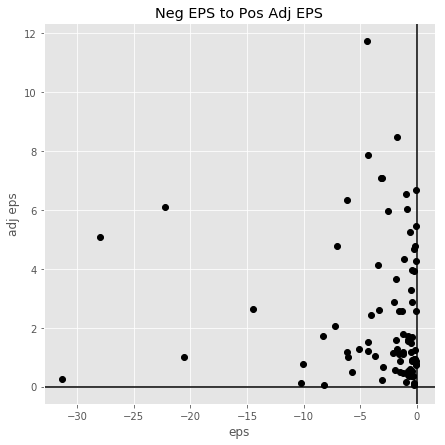

In [30]:
makePlot(df2[df2['neg_to_pos'] == 1]['eps'].values, df2[df2['neg_to_pos'] == 1]['adj_eps'].values,
         'Neg EPS to Pos Adj EPS', 'eps', 'adj eps', 'ko', xyline=False)

## The Benefit of Adjusting<a name="benefit"></a>
[Top](#top)

Below we look at the degree of improvement calculated as adjusted net earnings - net earnings divided by market cap. The data is the median for each industry group. The black horizontal line is the median improvement.

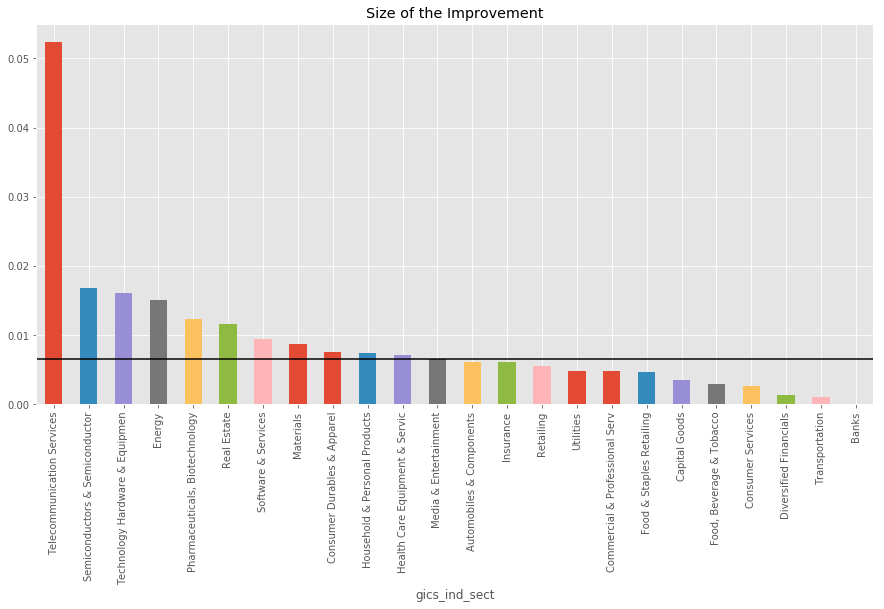

In [31]:
plt.figure(figsize=[10, 5])
(df2.groupby(df2['gics_ind_sect'])['adj_improve_gaap'].median().sort_values(ascending=False)
 .plot(kind='bar', figsize=[15, 7], title='Size of the Improvement'));
plt.axhline(df2['adj_improve_gaap'].median(), color='black');

The biggest beneficaries of the improvement tend to be in more technology related industries. Energy also appears to be a big beneficiary.

## Prevalence of Reporting<a name='usage'></a>
[Top](#top)

Returning back to our dataset that includes NA's since this includes companies that didn't use adjusted earnings, we can see the extent of the use of adjusted net income is each sector. Not surprisingly, given the performance of stocks when mseaured on non-GAAP earnings, non-GAAP usage has grown over time.

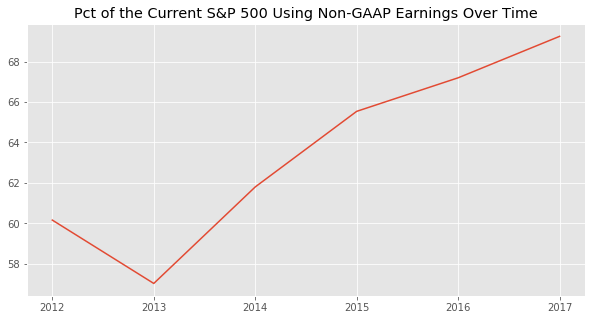

In [32]:
plt.figure(figsize=[10, 5])
plt.plot([2017, 2016, 2015, 2014, 2013, 2012],
         (df.groupby(df['year'])['adj_net_inc_as_rptd'].count()
          / df.groupby(df['year'])['net_inc'].count() * 100).values)
plt.title('Pct of the Current S&P 500 Using Non-GAAP Earnings Over Time');

Below we use a couple of techniques to create a new dataframe that summarizes the percentage usage by GICS Industry Group over the last 6 years.

In [33]:
gics = df2.groupby(df2['gics_ind_sect'])['adj_net_inc_as_rptd'].count().index
percentile = []
for x in range(0, 6):
    temp_df = df[df['year'] == x]
    percentile.append(dict(zip(gics, (temp_df.groupby(temp_df['gics_ind_sect'])['adj_net_inc_as_rptd'].count() /
                       temp_df.groupby(temp_df['gics_ind_sect'])['net_inc'].count()).values)))
percentile
gics_df = pd.DataFrame(percentile).transpose()
gics_df

,0,1,2,3,4,5
Automobiles & Components,0.666667,0.666667,0.666667,0.500000,0.333333,0.333333
Banks,0.473684,0.421053,0.368421,0.368421,0.263158,0.368421
Capital Goods,0.733333,0.644444,0.577778,0.600000,0.511111,0.568182
Commercial & Professional Serv,0.700000,0.600000,0.800000,0.700000,0.700000,0.500000
Consumer Durables & Apparel,0.684211,0.631579,0.473684,0.421053,0.526316,0.526316
Consumer Services,0.538462,0.538462,0.461538,0.461538,0.461538,0.461538
Diversified Financials,0.666667,0.592593,0.666667,0.555556,0.518519,0.555556
Energy,0.833333,0.866667,0.724138,0.689655,0.689655,0.517241
Food & Staples Retailing,0.600000,0.600000,0.600000,0.600000,0.600000,0.800000
"Food, Beverage & Tobacco",0.761905,0.666667,0.714286,0.666667,0.550000,0.600000


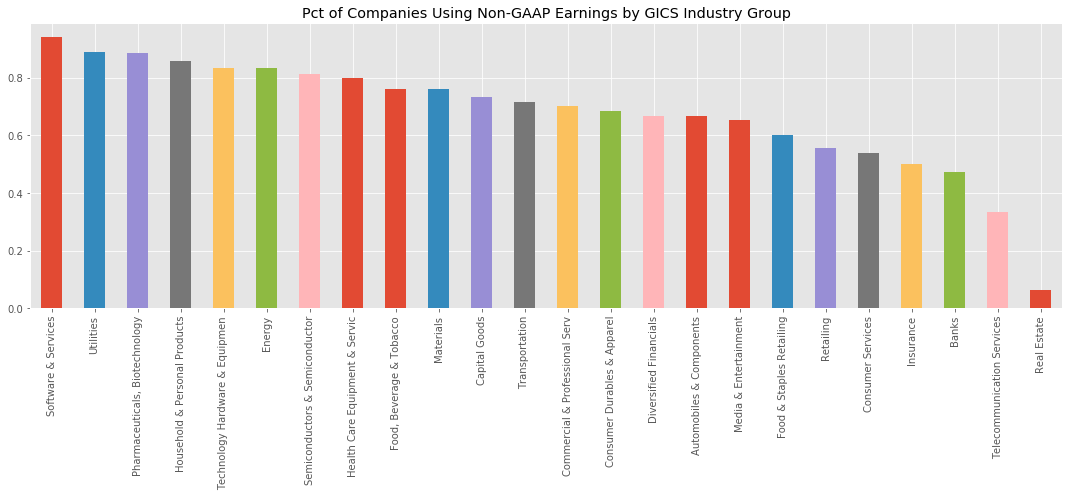

In [34]:
(gics_df[0].sort_values(ascending=False)
 .plot(kind='bar', figsize=[15, 7], 
       title='Pct of Companies Using Non-GAAP Earnings by GICS Industry Group'))
plt.tight_layout();

The chart above shows the percentage of companies reporting non-GAAP earnings by GICS industry group. It is only Banks, Telecommunication Services and Real Estate where less than half of the companies report non-GAAP earnings. It is not surprising that more information technology and biotechnology related sectors rely on non-GAAP. Apparently most utilities also report adjusted earnings as they back out the impact of various regulations...but if you're doing that, why not back out other "bad stuff", too. 

<img src="DUK RegG4Q2017.png">
<br>
A sample of one of the regulated utilities reporting adjusted earnings.

The chart below created from the table above illustrates the change between the most recent fiscal period and the period five years ago. The greatest increase came in the Automobile & Components industry from 1/3 of companies to 2/3. Four industry saw declines in usage, Food & Staples Retailing, Media & Entertainment, Real Estate and Telecommunication Services. 

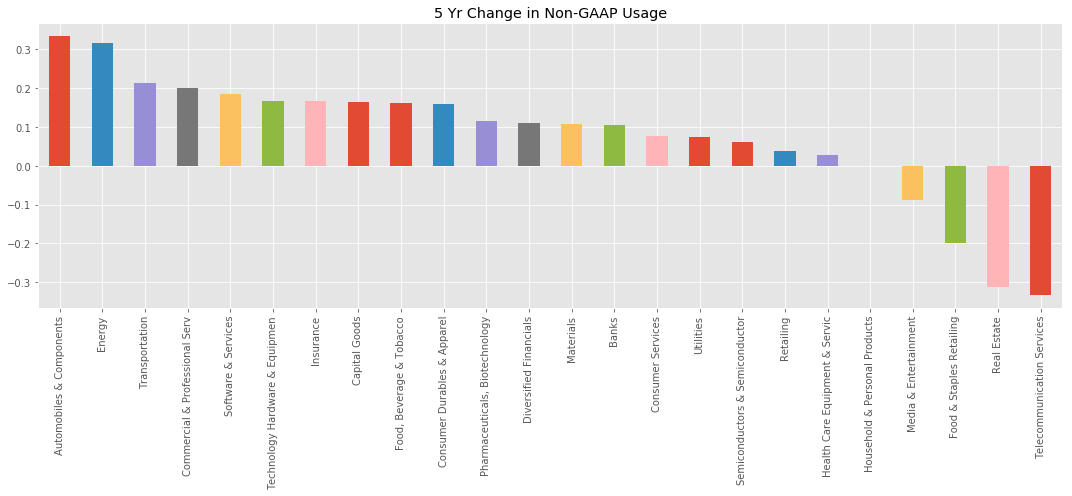

In [35]:
((gics_df[0] - gics_df[5]).sort_values(ascending=False).plot(kind='bar', figsize=[15, 7],
                                                             title='5 Yr Change in Non-GAAP Usage'))
plt.tight_layout();

[Top](#top)

## Conclusion<a name="conclusion"></a>
[Top](#top)

This exercise was to give a basic idea of the steps in a data analysis on a current topic. The number of variables is very low compared to a real-world analysis. Nor have I explored any machine learning algorithms to predict or classify. Nonetheless, even from the few variables there are some interesting facts that can be unearthed from a simple dataset.